### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

## About the Dataset

### IBM Synthetic AML Data
[This dataset](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/data?select=HI-Small_Trans.csv) is synthetic financial transaction data created by IBM to facilitate Anti-Money Laundering (AML) research, overcoming issues with real data like privacy and unreliable labeling.
- **Content:** Models a complete virtual financial ecosystem, tracking the entire money laundering cycle.
- **Key Advantage:** Provides accurate labels (Laundering or Legitimate) for all transactions and offers a full view across all virtual banks, which is essential for comprehensive model training.
- [HI-Small_Trans.csv: (High Illicit Activity)](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/data?select=HI-Small_Trans.csv) $\rightarrow$ Training/Validation.
- [LI-Small_Trans.csv: (Low Illicit Activity)](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/data?select=LI-Small_Trans.csv) $\rightarrow$ Testing.


In [2]:
df = pd.read_csv(r'C:\Users\user\Desktop\ML & DL projects\Anti- Money Laundering classification\data\HI-Small_Trans.csv')

### Exploratory Data Analysis (EDA)

In [3]:
df.head(5)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [4]:
df.shape

(5078345, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [6]:
df.isna().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

From the above analysis we found that the dataset has **5078345 rows** and **11 features**. It has 0 null values

In [7]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [8]:
df.columns = df.columns.str.replace(' ', '_').str.replace('.', '_').str.lower()
df.head(5)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [9]:
df.describe()

,from_bank,to_bank,amount_received,amount_paid,is_laundering
count,5078345.00,5078345.00,5078345.00,5078345.00,5078345.00
mean,45730.57,65744.56,5988726.07,4509273.37,0.00
std,81765.62,84092.99,1037183108.89,869772830.92,0.03
min,1.00,1.00,0.00,0.00,0.00
25%,119.00,4259.00,183.37,184.48,0.00
50%,9679.00,21568.00,1411.01,1414.54,0.00
75%,28628.00,122332.00,12346.27,12297.84,0.00
max,356303.00,356294.00,1046302363293.48,1046302363293.48,1.00


In [10]:
df.describe(include = ['bool', 'object'])

,timestamp,account,account_1,receiving_currency,payment_currency,payment_format
count,5078345,5078345,5078345,5078345,5078345,5078345
unique,15018,496995,420636,15,15,7
top,2022/09/01 00:04,100428660,100428660,US Dollar,US Dollar,Cheque
freq,11193,168672,1084,1879341,1895172,1864331


In [11]:
df.is_laundering.value_counts()

is_laundering
0    5073168
1       5177
Name: count, dtype: int64

In [12]:
df.is_laundering.value_counts()*100/df.shape[0]

is_laundering
0   99.90
1    0.10
Name: count, dtype: float64

From the above calculation, we find out that frauds are very less as compared to non fraud instances and this leaves a problem as we wont be able to train our model properly.

Before we split the dataset though we need to conduct a through analysis and may need to change the values which do not result in data leakage. these data transformations would be the ones that dont use the values in the dataset the change or update other values in the dataset.

### Addressing Class Imbalance and Data Preparation
The initial analysis reveals a significant class imbalance in the dataset, where the number of money laundering (fraudulent) instances is extremely small compared to legitimate transactions.

#### The Challenge: Class Imbalance
Training a machine learning model directly on a severely imbalanced dataset presents significant problems:
- The model may become biased towards the majority class (legitimate transactions).
- It often results in poor predictive performance on the rare, critical minority class (laundering transactions), leading to a high number of false negatives (undetected laundering).

#### Strategic Data Transformation and Leakage Prevention
Before splitting the data for training and testing, it is essential to perform robust feature engineering and data transformations. These transformations must strictly adhere to best practices to avoid data leakage.
- **Data Leakage:** This occurs when information from the test set is inadvertently used to create or optimize the training data, leading to overly optimistic performance metrics that do not generalize to real-world data.
- **Right Practices:** We must prioritize transformations that are self-contained and do not utilize information from across the entire dataset to modify individual instances (e.g., standard scaling, which uses global mean/variance, should be deferred until after the split).

### Payement Type

here we will be conducting some analysis to find out more about when laundering is more likely to take place

In [13]:
df_launder = df[df.is_laundering ==1]
df_launder.sample(5)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
4462855,2022/09/09 08:39,16354,803D77AB0,21918,803D77BA0,3642.93,Euro,3642.93,Euro,ACH,1
1442837,2022/09/02 10:14,12446,80C542DF0,114674,80C543AA0,3612.04,US Dollar,3612.04,US Dollar,ACH,1
3077364,2022/09/06 15:02,121453,80D288860,26024,80D289A20,3317.54,US Dollar,3317.54,US Dollar,ACH,1
2556471,2022/09/05 13:07,9482,80C3342B0,227143,80C2FB3F0,1757.81,US Dollar,1757.81,US Dollar,ACH,1
1639617,2022/09/04 14:05,119,811C597B0,222,811B83280,724.01,Saudi Riyal,724.01,Saudi Riyal,ACH,1


In [14]:
df_launder['payment_format'].value_counts()*100/df_launder['payment_format'].shape[0]

payment_format
ACH           86.59
Cheque         6.26
Credit Card    3.98
Cash           2.09
Bitcoin        1.08
Name: count, dtype: float64

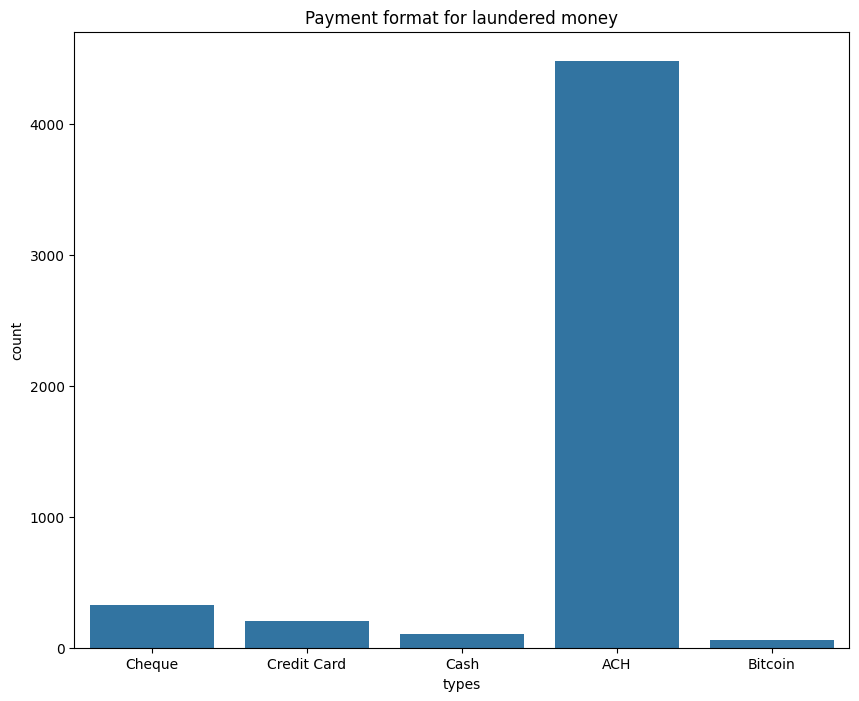

In [15]:
plt.figure(figsize=(10,8))
sns.countplot(data =df_launder, x = 'payment_format')
plt.title('Payment format for laundered money')
plt.xlabel('types')
plt.ylabel('count')
plt.show()

In [16]:
df['payment_format'].value_counts()*100/df['payment_format'].shape[0]

payment_format
Cheque         36.71
Credit Card    26.06
ACH            11.83
Cash            9.67
Reinvestment    9.47
Wire            3.38
Bitcoin         2.88
Name: count, dtype: float64

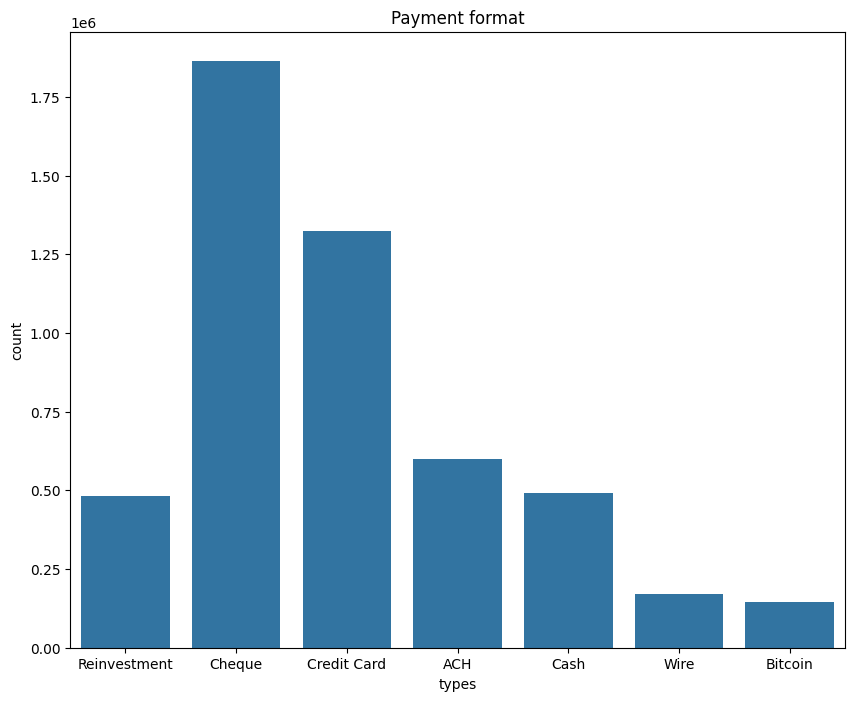

In [17]:
plt.figure(figsize=(10,8))
sns.countplot(data =df, x = 'payment_format')
plt.title('Payment format')
plt.xlabel('types')
plt.ylabel('count')
plt.show()

from the above analysis we can infer few things:
when it comes to general transactions, the top 3 choices for money exchange are ACH, cheques and credit cards
when it comes to laundered causes, those three again comes at top.
so we are gonna list htem as major classes and group everything as together as 'Others' for ease of computation later on.

### Feature Consolidation: Payment Type
Analysis shows that the majority of both legitimate and laundered transactions are conducted via: **ACH, Cheque, and Credit Card**.
To simplify the model and improve computational efficiency, we will consolidate the transaction type feature:
- The top three methods (ACH, Cheque, Credit Card) will remain distinct classes.
- All other low-frequency transaction types will be grouped into a single category labeled 'Others'.
This strategy retains the most discriminative information while reducing dimensionality.

In [18]:
# we make a copy and perform feature engineering on them
df1 = df.copy()
df1['payment_format'] = df1['payment_format'].apply(lambda x: x if x in ['Cheque', 'Credit Card', 'ACH'] else 'Others')

In [19]:
df_launder['payment_format'] = df_launder['payment_format'].apply(lambda x: x if x in ['Cheque', 'Credit Card', 'ACH'] else 'Others')

df1['payment_format'].value_counts()*100/df1['payment_format'].shape[0]

payment_format
Cheque        36.71
Credit Card   26.06
Others        25.40
ACH           11.83
Name: count, dtype: float64

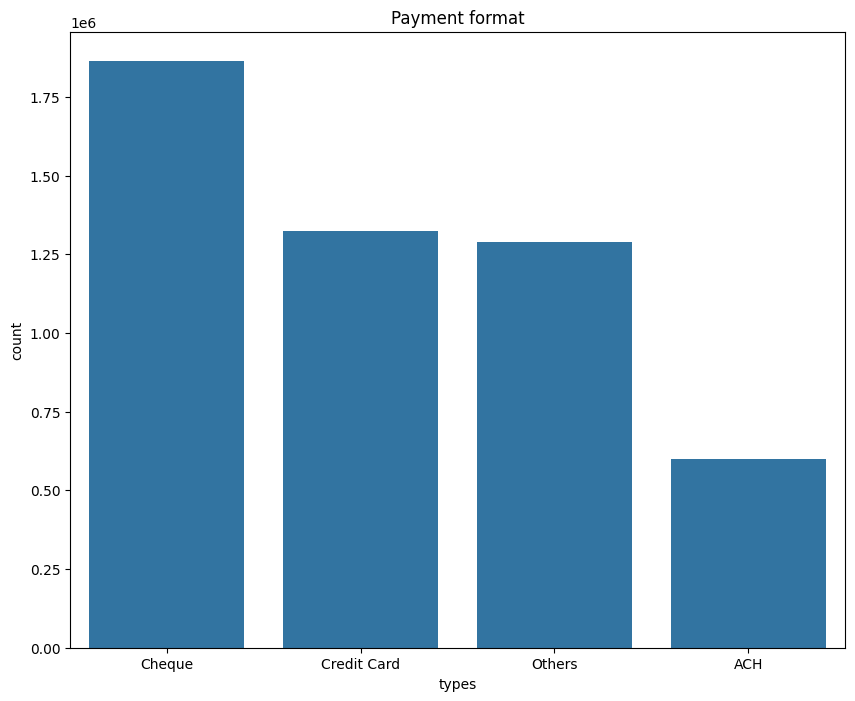

In [20]:
order2 = df1['payment_format'].value_counts().index
plt.figure(figsize=(10,8))
sns.countplot(data =df1, x = 'payment_format', order=order2)
plt.title('Payment format')
plt.xlabel('types')
plt.ylabel('count')
plt.show()

In [21]:
df_launder['payment_format'].value_counts()*100/df_launder['payment_format'].shape[0]

payment_format
ACH           86.59
Cheque         6.26
Credit Card    3.98
Others         3.17
Name: count, dtype: float64

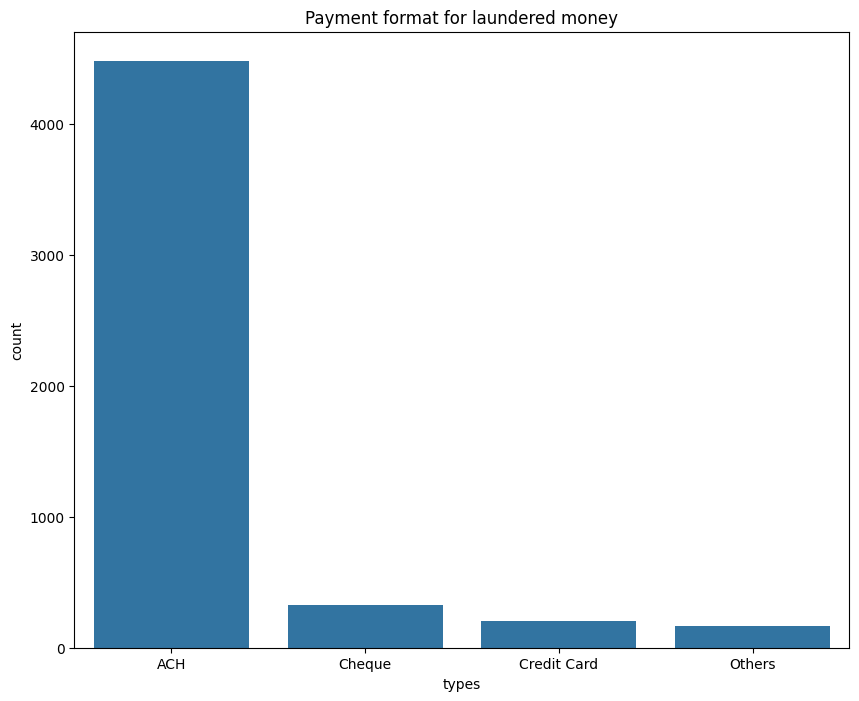

In [22]:
order2 = df_launder['payment_format'].value_counts().index
plt.figure(figsize=(10,8))
sns.countplot(data =df_launder, x = 'payment_format', order = order2)
plt.title('Payment format for laundered money')
plt.xlabel('types')
plt.ylabel('count')
plt.show()

### Payment Currency and Received Currency

In [23]:
df1.sample(2)

,timestamp,from_bank,account,to_bank,account_1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
2905637,2022/09/06 06:14,18200,80310E820,3,8031DE490,27322.02,Yuan,27322.02,Yuan,Credit Card,0
2269246,2022/09/04 22:28,10,800251320,220,80078E8F0,190.40,US Dollar,190.40,US Dollar,Cheque,0


### Payment Currency

In [24]:
df1['payment_currency'].value_counts()*100/df1['payment_currency'].shape[0]

payment_currency
US Dollar           37.32
Euro                23.01
Swiss Franc          4.62
Yuan                 4.21
Shekel               3.78
Rupee                3.75
UK Pound             3.56
Yen                  3.06
Ruble                3.06
Bitcoin              2.88
Canadian Dollar      2.76
Australian Dollar    2.69
Mexican Peso         2.17
Saudi Riyal          1.75
Brazil Real          1.39
Name: count, dtype: float64

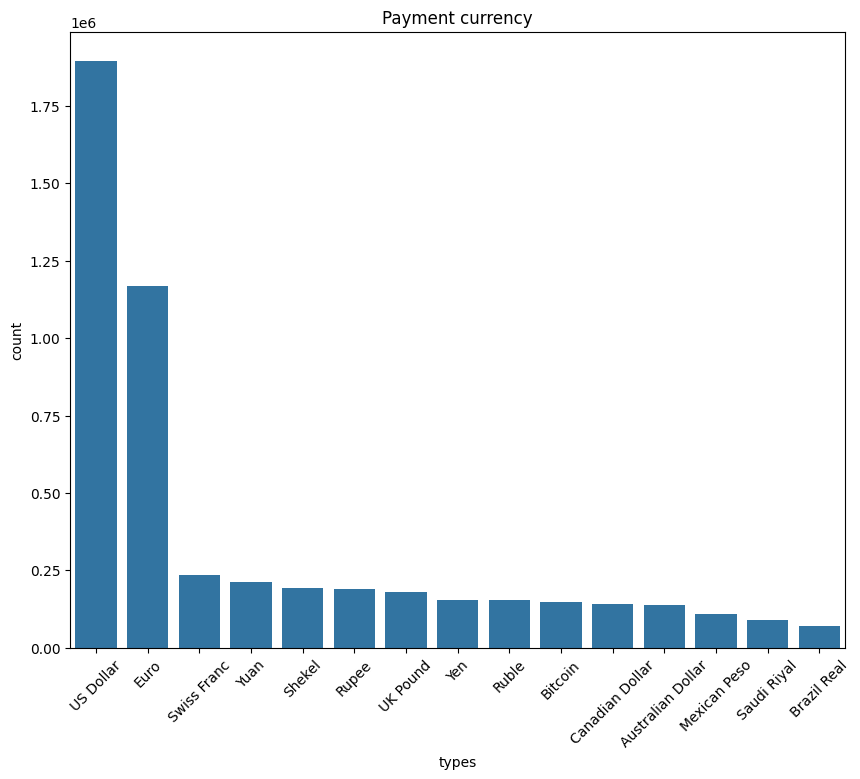

In [25]:
order2 = df1['payment_currency'].value_counts().index
plt.figure(figsize=(10,8))
sns.countplot(data =df1, x = 'payment_currency', order= order2)
plt.title('Payment currency')
plt.xlabel('types')
plt.ylabel('count')
plt.xticks(rotation = 45)
plt.show()

### Receiving Currency

In [26]:
df1['receiving_currency'].value_counts()*100/df1['payment_currency'].shape[0]

receiving_currency
US Dollar           37.01
Euro                23.08
Swiss Franc          4.68
Yuan                 4.07
Shekel               3.84
Rupee                3.78
UK Pound             3.57
Ruble                3.10
Yen                  3.08
Bitcoin              2.92
Canadian Dollar      2.78
Australian Dollar    2.73
Mexican Peso         2.19
Saudi Riyal          1.77
Brazil Real          1.41
Name: count, dtype: float64

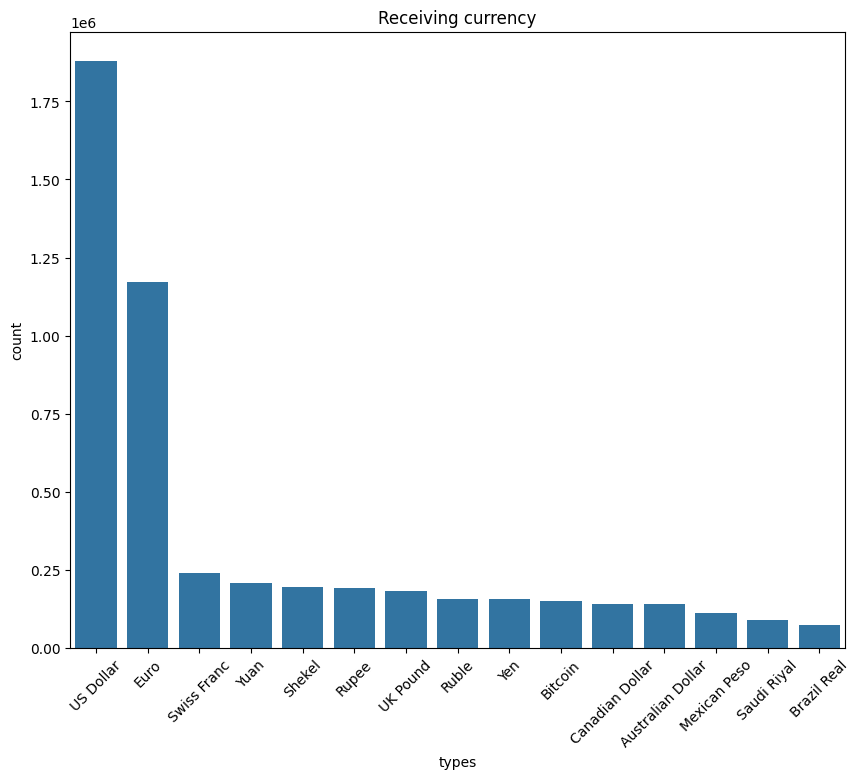

In [27]:
order2 = df1['receiving_currency'].value_counts().index
plt.figure(figsize=(10,8))
sns.countplot(data =df1, x = 'receiving_currency', order= order2)
plt.title('Receiving currency')
plt.xlabel('types')
plt.ylabel('count')
plt.xticks(rotation = 45)
plt.show()

### Feature Consolidation: Currency Type
Based on transaction volume, four currencies significantly dominate the dataset. While **US Dollar and Euro are the largest, Swiss Franc and Yuan also show high volume**
To reduce dimensionality and focus the model on high-volume activity, we will consolidate the currency feature:
- US Dollar, Euro, Franc, and Yuan will remain distinct categories.
- All other low-volume currencies will be grouped into the 'Other' category.

In [28]:
df1['receiving_currency'] = df1['receiving_currency'].apply(lambda x: x if x in ['US Dollar', 'Euro', 'Swiss Franc', 'Yuan'] else 'Others')
df1['payment_currency'] = df1['payment_currency'].apply(lambda x: x if x in ['US Dollar', 'Euro', 'Swiss Franc', 'Yuan'] else 'Others')

In [29]:
df1.payment_currency.value_counts()*100/df1.payment_currency.shape[0]

payment_currency
US Dollar     37.32
Others        30.84
Euro          23.01
Swiss Franc    4.62
Yuan           4.21
Name: count, dtype: float64

In [30]:
df1.receiving_currency.value_counts()*100/df1.receiving_currency.shape[0]

receiving_currency
US Dollar     37.01
Others        31.16
Euro          23.08
Swiss Franc    4.68
Yuan           4.07
Name: count, dtype: float64

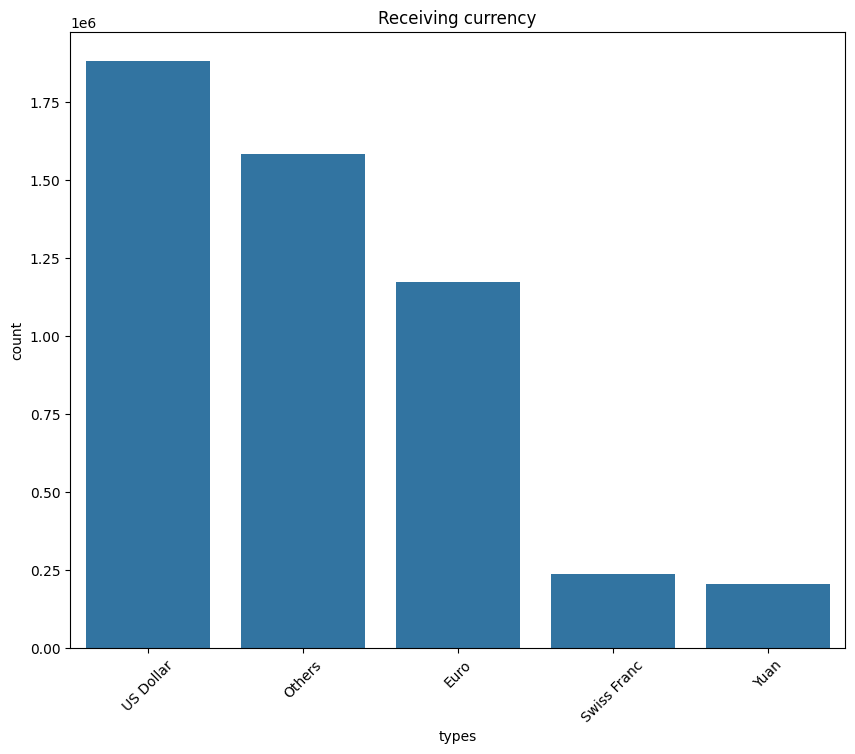

In [31]:
order2 = df1['receiving_currency'].value_counts().index
plt.figure(figsize=(10,8))
sns.countplot(data =df1, x = 'receiving_currency', order= order2)
plt.title('Receiving currency')
plt.xlabel('types')
plt.ylabel('count')
plt.xticks(rotation = 45)
plt.show()

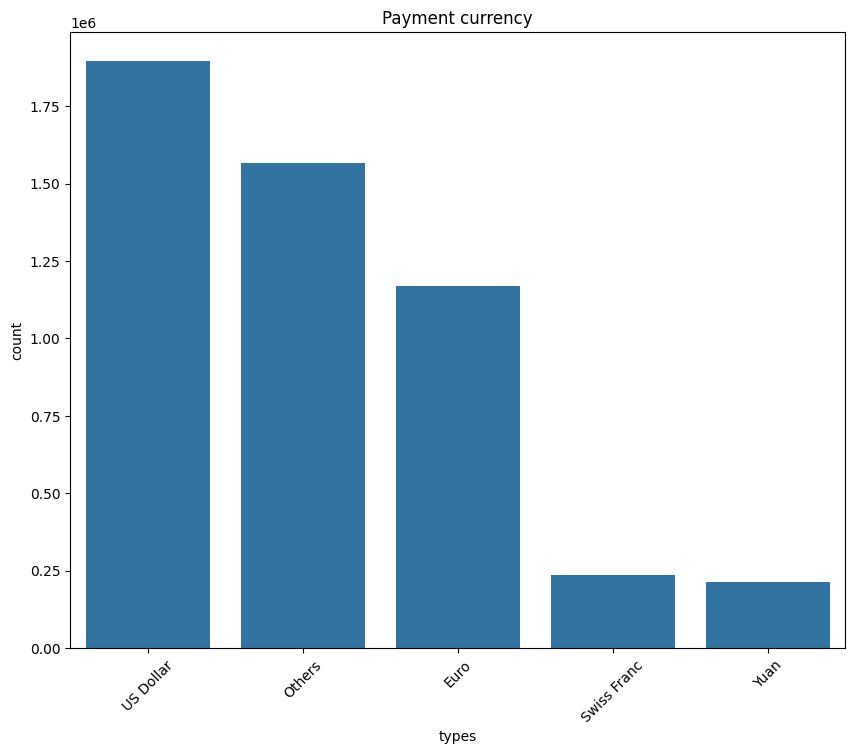

In [32]:
order2 = df1['payment_currency'].value_counts().index
plt.figure(figsize=(10,8))
sns.countplot(data =df1, x = 'payment_currency', order= order2)
plt.title('Payment currency')
plt.xlabel('types')
plt.ylabel('count')
plt.xticks(rotation = 45)
plt.show()

In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   timestamp           object 
 1   from_bank           int64  
 2   account             object 
 3   to_bank             int64  
 4   account_1           object 
 5   amount_received     float64
 6   receiving_currency  object 
 7   amount_paid         float64
 8   payment_currency    object 
 9   payment_format      object 
 10  is_laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


##### now we will seperate the time columns into different components

In [34]:
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1['year'] = df1['timestamp'].dt.year
df1['month'] = df1['timestamp'].dt.month
df1['day'] = df1['timestamp'].dt.day

In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   timestamp           datetime64[ns]
 1   from_bank           int64         
 2   account             object        
 3   to_bank             int64         
 4   account_1           object        
 5   amount_received     float64       
 6   receiving_currency  object        
 7   amount_paid         float64       
 8   payment_currency    object        
 9   payment_format      object        
 10  is_laundering       int64         
 11  year                int32         
 12  month               int32         
 13  day                 int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(3), object(5)
memory usage: 484.3+ MB


We extract only **Year, Month, and Day** from the timestamp because these components capture the meaningful temporal patterns in our dataset. Finer details such as hour, minute, and second do not contribute useful predictive value for this problem and would introduce unnecessary noise and complexity. Therefore, limiting the extraction to year–month–day ensures cleaner, more relevant features for model training.

In [36]:
df1.year.value_counts()

year
2022    5078345
Name: count, dtype: int64

In [37]:
df1.month.value_counts()

month
9    5078345
Name: count, dtype: int64

In [38]:
df1.day.value_counts()

day
1     1114921
2      754449
9      654467
8      482773
7      482751
5      482650
6      482089
10     208325
4      207430
3      207382
11        396
12        281
13        184
14        121
15         46
16         46
17         23
18         11
Name: count, dtype: int64

Since the year and month columns contain only single constant values (2022 and September), they do not provide any variance or predictive value for the model. Features with no variation cannot help the model differentiate between data points and only add unnecessary dimensionality. Therefore, we drop the timestamp, year, and month columns to reduce computational complexity and maintain a cleaner, more efficient feature set.

In [39]:
df1.drop(columns=['timestamp', 'year', 'month'], axis = 1, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   from_bank           int64  
 1   account             object 
 2   to_bank             int64  
 3   account_1           object 
 4   amount_received     float64
 5   receiving_currency  object 
 6   amount_paid         float64
 7   payment_currency    object 
 8   payment_format      object 
 9   is_laundering       int64  
 10  day                 int32  
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 406.8+ MB


Next, we apply one-hot encoding to payment_currency, received_currency, and payment_methods to convert these categorical fields into numerical form while preserving their non-ordinal nature. This prepares the data for effective model training.

In [40]:
df2 = df1.copy()
df2 = pd.get_dummies(data = df2, columns = ['receiving_currency','payment_currency', 'payment_format'], drop_first=True)

In [41]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 19 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   from_bank                       int64  
 1   account                         object 
 2   to_bank                         int64  
 3   account_1                       object 
 4   amount_received                 float64
 5   amount_paid                     float64
 6   is_laundering                   int64  
 7   day                             int32  
 8   receiving_currency_Others       bool   
 9   receiving_currency_Swiss Franc  bool   
 10  receiving_currency_US Dollar    bool   
 11  receiving_currency_Yuan         bool   
 12  payment_currency_Others         bool   
 13  payment_currency_Swiss Franc    bool   
 14  payment_currency_US Dollar      bool   
 15  payment_currency_Yuan           bool   
 16  payment_format_Cheque           bool   
 17  payment_format_Credit Card 

In [42]:
df2.sample(5)

,from_bank,account,to_bank,account_1,amount_received,amount_paid,is_laundering,day,receiving_currency_Others,receiving_currency_Swiss Franc,receiving_currency_US Dollar,receiving_currency_Yuan,payment_currency_Others,payment_currency_Swiss Franc,payment_currency_US Dollar,payment_currency_Yuan,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
1592338,223,811A01A60,118,811A02890,2631.54,2631.54,0,2,True,False,False,False,True,False,False,False,False,False,False
2744686,70,100428738,24,80456AF80,133376.13,133376.13,0,5,True,False,False,False,True,False,False,False,True,False,False
3308821,23344,805793F70,111141,808608B80,410.06,410.06,0,7,False,False,False,False,False,False,False,False,False,False,False
2591401,12,80BF27590,131086,80C198B70,1773.64,1773.64,0,5,True,False,False,False,True,False,False,False,True,False,False
4450043,1655,800C5B2A0,111326,808F3D0C0,32.19,32.19,0,9,False,False,False,False,False,False,False,False,True,False,False


In [43]:
df2.describe()

,from_bank,to_bank,amount_received,amount_paid,is_laundering,day
count,5078345.00,5078345.00,5078345.00,5078345.00,5078345.00,5078345.00
mean,45730.57,65744.56,5988726.07,4509273.37,0.00,4.85
std,81765.62,84092.99,1037183108.89,869772830.92,0.03,3.08
min,1.00,1.00,0.00,0.00,0.00,1.00
25%,119.00,4259.00,183.37,184.48,0.00,2.00
50%,9679.00,21568.00,1411.01,1414.54,0.00,5.00
75%,28628.00,122332.00,12346.27,12297.84,0.00,8.00
max,356303.00,356294.00,1046302363293.48,1046302363293.48,1.00,18.00


In [44]:
df2.describe(include = ['bool', 'object'])

,account,account_1,receiving_currency_Others,receiving_currency_Swiss Franc,receiving_currency_US Dollar,receiving_currency_Yuan,payment_currency_Others,payment_currency_Swiss Franc,payment_currency_US Dollar,payment_currency_Yuan,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
count,5078345,5078345,5078345,5078345,5078345,5078345,5078345,5078345,5078345,5078345,5078345,5078345,5078345
unique,496995,420636,2,2,2,2,2,2,2,2,2,2,2
top,100428660,100428660,False,False,False,False,False,False,False,False,False,False,False
freq,168672,1084,3495793,4840461,3199004,4871794,3512081,4843485,3183173,4864593,3214014,3755021,3788452


Although the amount_received and amount_paid columns contain a large number of outliers, we choose to retain them because these extreme values may represent genuine high-value transactions rather than errors. Removing them could distort the underlying distribution and lead to loss of important patterns relevant to the problem. Keeping the dataset intact ensures that the model learns from the full range of transaction behaviors.

We first split the data into training and validation sets to ensure unbiased model evaluation. After the split, we apply frequency encoding to the from_bank, account, to_bank, and account_1 columns. These features contain high-cardinality categorical values, and frequency encoding provides an efficient way to represent them numerically without inflating the feature space. This approach preserves meaningful distributional information while keeping the model computationally efficient.

In [45]:
# doing this so that I can use it for training autoencoders later on

import joblib
from joblib import dump

dump((df2), 'dataset_autoencoder.joblib')


['dataset_autoencoder.joblib']

### Understampling the Dataset

We will split the data first and then perform all the required transformations and apply frequency encoding and imbalace handling techniques like SMOTE and so on. This is done to avoid Data Leakage. Here the the changes and transformation that are done on training dataset will also be performed on test dataset

In [46]:
from imblearn.under_sampling import RandomUnderSampler
import math

chunk_size = 100_000
n = len(df)
num_chunks = math.ceil(n / chunk_size)

rus = RandomUnderSampler(
    sampling_strategy=0.1,  # keep 10% majority
    random_state=42
)

balanced_chunks = []

for i in range(num_chunks):
    chunk = df2.iloc[i*chunk_size : (i+1)*chunk_size]

    X_chunk = chunk.drop("is_laundering", axis=1)
    y_chunk = chunk["is_laundering"]

    if len(y_chunk.unique()) > 1:  # only process chunks with both labels
        X_res, y_res = rus.fit_resample(X_chunk, y_chunk)
        balanced_chunks.append(pd.concat([X_res, y_res], axis=1))

df_balanced1 = pd.concat(balanced_chunks, ignore_index=True)
print(df_balanced1["is_laundering"].value_counts())

is_laundering
0    51770
1     5177
Name: count, dtype: int64


In [47]:
df_balanced1.head(5)

,from_bank,account,to_bank,account_1,amount_received,amount_paid,day,receiving_currency_Others,receiving_currency_Swiss Franc,receiving_currency_US Dollar,receiving_currency_Yuan,payment_currency_Others,payment_currency_Swiss Franc,payment_currency_US Dollar,payment_currency_Yuan,payment_format_Cheque,payment_format_Credit Card,payment_format_Others,is_laundering
0,2845,8048442A0,2845,8048442A0,8474.24,8474.24,1,False,False,True,False,False,False,True,False,False,False,True,0
1,13145,803EA82D0,13145,803EA82D0,351811.03,351811.03,1,False,False,True,False,False,False,True,False,False,False,True,0
2,23537,808094A70,23537,808094A70,18.71,18.71,1,False,False,True,False,False,False,True,False,False,False,True,0
3,70,100428660,1601,8010D01B0,40228.29,40228.29,1,False,False,True,False,False,False,True,False,True,False,False,0
4,11318,800C4B390,11318,800C4B390,40068.30,40068.30,1,False,False,True,False,False,False,True,False,False,False,True,0


In [48]:
X1 = df_balanced1.drop(columns='is_laundering', axis=1)
y1 = df_balanced1['is_laundering']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, stratify= y1)

In [49]:
X_train1.columns

Index(['from_bank', 'account', 'to_bank', 'account_1', 'amount_received',
       'amount_paid', 'day', 'receiving_currency_Others',
       'receiving_currency_Swiss Franc', 'receiving_currency_US Dollar',
       'receiving_currency_Yuan', 'payment_currency_Others',
       'payment_currency_Swiss Franc', 'payment_currency_US Dollar',
       'payment_currency_Yuan', 'payment_format_Cheque',
       'payment_format_Credit Card', 'payment_format_Others'],
      dtype='object')

### Frequency Encoding

Frequency encoding is used for the variables from_bank, to_bank, account, and account_1 to handle their large number of unique categories. This method represents each category by its frequency in the dataset, capturing usage patterns relevant to detecting money-laundering while avoiding the high dimensionality and performance issues associated with one-hot encoding.

In [50]:
columns_to_change = ['from_bank', 'account', 'to_bank', 'account_1']

for col in columns_to_change:
    freq = X_train1[col].value_counts(normalize=True)
    X_train1[col] = X_train1[col].map(freq)

    freq_test = X_test1[col].value_counts(normalize=True)
    X_test1[col] = X_test1[col].map(freq_test)

In [51]:
X_train1.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,day,receiving_currency_Others,receiving_currency_Swiss Franc,receiving_currency_US Dollar,receiving_currency_Yuan,payment_currency_Others,payment_currency_Swiss Franc,payment_currency_US Dollar,payment_currency_Yuan,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
37973,0.00,0.00,0.00,0.00,93600.84,93600.84,7,False,False,True,False,False,False,True,False,True,False,False
9572,0.00,0.00,0.00,0.00,58.98,58.98,2,False,False,True,False,False,False,True,False,False,False,True
53707,0.00,0.00,0.00,0.00,19833.92,19833.92,10,False,True,False,False,False,True,False,False,False,True,False
49897,0.00,0.00,0.00,0.00,315240.81,315240.81,9,True,False,False,False,True,False,False,False,False,False,False
4074,0.02,0.00,0.00,0.00,53.03,53.03,1,False,False,True,False,False,False,True,False,True,False,False


In [52]:
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45557 entries, 37973 to 52708
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   from_bank                       45557 non-null  float64
 1   account                         45557 non-null  float64
 2   to_bank                         45557 non-null  float64
 3   account_1                       45557 non-null  float64
 4   amount_received                 45557 non-null  float64
 5   amount_paid                     45557 non-null  float64
 6   day                             45557 non-null  int32  
 7   receiving_currency_Others       45557 non-null  bool   
 8   receiving_currency_Swiss Franc  45557 non-null  bool   
 9   receiving_currency_US Dollar    45557 non-null  bool   
 10  receiving_currency_Yuan         45557 non-null  bool   
 11  payment_currency_Others         45557 non-null  bool   
 12  payment_currency_Swiss Franc    4

Robust scaling handles outliers better than normalization or standardization by minimizing their influence while scaling numerical features. This ensures stable transformations and preserves the integrity of the data distribution for analysis and modeling.

In [53]:
robust_scaler = RobustScaler()
columns_to_scale = ['amount_received', 'amount_paid']

X_train1[columns_to_scale] = robust_scaler.fit_transform(X_train1[columns_to_scale])
X_test1[columns_to_scale] = robust_scaler.transform(X_test1[columns_to_scale])

X_train1.head()


,from_bank,account,to_bank,account_1,amount_received,amount_paid,day,receiving_currency_Others,receiving_currency_Swiss Franc,receiving_currency_US Dollar,receiving_currency_Yuan,payment_currency_Others,payment_currency_Swiss Franc,payment_currency_US Dollar,payment_currency_Yuan,payment_format_Cheque,payment_format_Credit Card,payment_format_Others
37973,0.00,0.00,0.00,0.00,7.41,7.42,7,False,False,True,False,False,False,True,False,True,False,False
9572,0.00,0.00,0.00,0.00,-0.13,-0.13,2,False,False,True,False,False,False,True,False,False,False,True
53707,0.00,0.00,0.00,0.00,1.46,1.47,10,False,True,False,False,False,True,False,False,False,True,False
49897,0.00,0.00,0.00,0.00,25.28,25.32,9,True,False,False,False,True,False,False,False,False,False,False
4074,0.02,0.00,0.00,0.00,-0.13,-0.13,1,False,False,True,False,False,False,True,False,True,False,False


In [54]:
## we are using smotetomek and checking another kind of dataset
smt = SMOTETomek(sampling_strategy=0.25, random_state=42)
X_train2, y_train2 = smt.fit_resample(X_train1, y_train1)

In [55]:
y_train2.value_counts()

is_laundering
0    40109
1     9047
Name: count, dtype: int64

In [59]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49156 entries, 0 to 49155
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   from_bank                       49156 non-null  float64
 1   account                         49156 non-null  float64
 2   to_bank                         49156 non-null  float64
 3   account_1                       49156 non-null  float64
 4   amount_received                 49156 non-null  float64
 5   amount_paid                     49156 non-null  float64
 6   day                             49156 non-null  int32  
 7   receiving_currency_Others       49156 non-null  bool   
 8   receiving_currency_Swiss Franc  49156 non-null  bool   
 9   receiving_currency_US Dollar    49156 non-null  bool   
 10  receiving_currency_Yuan         49156 non-null  bool   
 11  payment_currency_Others         49156 non-null  bool   
 12  payment_currency_Swiss Franc    

In [61]:
df3 = pd.concat([X_train2, y_train2], axis=1)

In [62]:
df3.head()

,from_bank,account,to_bank,account_1,amount_received,amount_paid,day,receiving_currency_Others,receiving_currency_Swiss Franc,receiving_currency_US Dollar,receiving_currency_Yuan,payment_currency_Others,payment_currency_Swiss Franc,payment_currency_US Dollar,payment_currency_Yuan,payment_format_Cheque,payment_format_Credit Card,payment_format_Others,is_laundering
0,0.00,0.00,0.00,0.00,7.41,7.42,7,False,False,True,False,False,False,True,False,True,False,False,0
1,0.00,0.00,0.00,0.00,-0.13,-0.13,2,False,False,True,False,False,False,True,False,False,False,True,0
2,0.00,0.00,0.00,0.00,1.46,1.47,10,False,True,False,False,False,True,False,False,False,True,False,0
3,0.00,0.00,0.00,0.00,25.28,25.32,9,True,False,False,False,True,False,False,False,False,False,False,0
4,0.02,0.00,0.00,0.00,-0.13,-0.13,1,False,False,True,False,False,False,True,False,True,False,False,0


In [64]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49156 entries, 0 to 49155
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   from_bank                       49156 non-null  float64
 1   account                         49156 non-null  float64
 2   to_bank                         49156 non-null  float64
 3   account_1                       49156 non-null  float64
 4   amount_received                 49156 non-null  float64
 5   amount_paid                     49156 non-null  float64
 6   day                             49156 non-null  int32  
 7   receiving_currency_Others       49156 non-null  bool   
 8   receiving_currency_Swiss Franc  49156 non-null  bool   
 9   receiving_currency_US Dollar    49156 non-null  bool   
 10  receiving_currency_Yuan         49156 non-null  bool   
 11  payment_currency_Others         49156 non-null  bool   
 12  payment_currency_Swiss Franc    

In [ ]:
bool_cols = df3.select_dtypes(include="bool").columns
df3[bool_cols] = df3[bool_cols].astype(int)

In [66]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49156 entries, 0 to 49155
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   from_bank                       49156 non-null  float64
 1   account                         49156 non-null  float64
 2   to_bank                         49156 non-null  float64
 3   account_1                       49156 non-null  float64
 4   amount_received                 49156 non-null  float64
 5   amount_paid                     49156 non-null  float64
 6   day                             49156 non-null  int32  
 7   receiving_currency_Others       49156 non-null  int64  
 8   receiving_currency_Swiss Franc  49156 non-null  int64  
 9   receiving_currency_US Dollar    49156 non-null  int64  
 10  receiving_currency_Yuan         49156 non-null  int64  
 11  payment_currency_Others         49156 non-null  int64  
 12  payment_currency_Swiss Franc    

In [68]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(df, target_col=None):
    """
    Calculate Variance Inflation Factor (VIF) for each numeric column in df.
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int32', 'int64']).copy()

    # Drop target if provided
    if target_col and target_col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[target_col])

    # Add constant for statsmodels
    X = add_constant(numeric_df)

    # Compute VIF (skip the first column = constant)
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i + 1)  # skip constant at index 0
        for i in range(len(numeric_df.columns))
    ]

    return vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)


# Look at VIF and correlation with original training dataset
#df = pd.read_csv(r"C:\Users\user\Desktop\ML & DL projects\Mlops_house_prediction\data\raw\train.csv")
vif_table = calculate_vif(df3, target_col="is_laundering")
print(vif_table)

                           feature   VIF
0   receiving_currency_Swiss Franc 65.75
1     payment_currency_Swiss Franc 65.73
2          payment_currency_Others 60.20
3        receiving_currency_Others 60.10
4       payment_currency_US Dollar 35.13
5     receiving_currency_US Dollar 35.06
6            payment_currency_Yuan 23.36
7          receiving_currency_Yuan 23.22
8                  amount_received 12.50
9                      amount_paid 12.49
10                         account  2.88
11                       from_bank  2.83
12           payment_format_Cheque  1.78
13      payment_format_Credit Card  1.65
14           payment_format_Others  1.61
15                       account_1  1.15
16                             day  1.05
17                         to_bank  1.02


In [56]:
import joblib
from joblib import dump

dump((X_train1, y_train1, X_test1, y_test1), 'dataset_splits.joblib')


['dataset_splits.joblib']

In [57]:
# for smote applied one
import joblib
from joblib import dump

dump((X_train2, y_train2, X_test1, y_test1), 'smote_dataset_splits.joblib')

['smote_dataset_splits.joblib']

In [58]:
# importing the datasets

import joblib
from joblib import load

X_train1, y_train1, X_test1, y_test1 = joblib.load('dataset_splits.joblib')